In [15]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os

from torchvision.models import mobilenet_v3_small, mobilenet_v3_large

import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import pairwise_distances
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

### Prepare Dataset

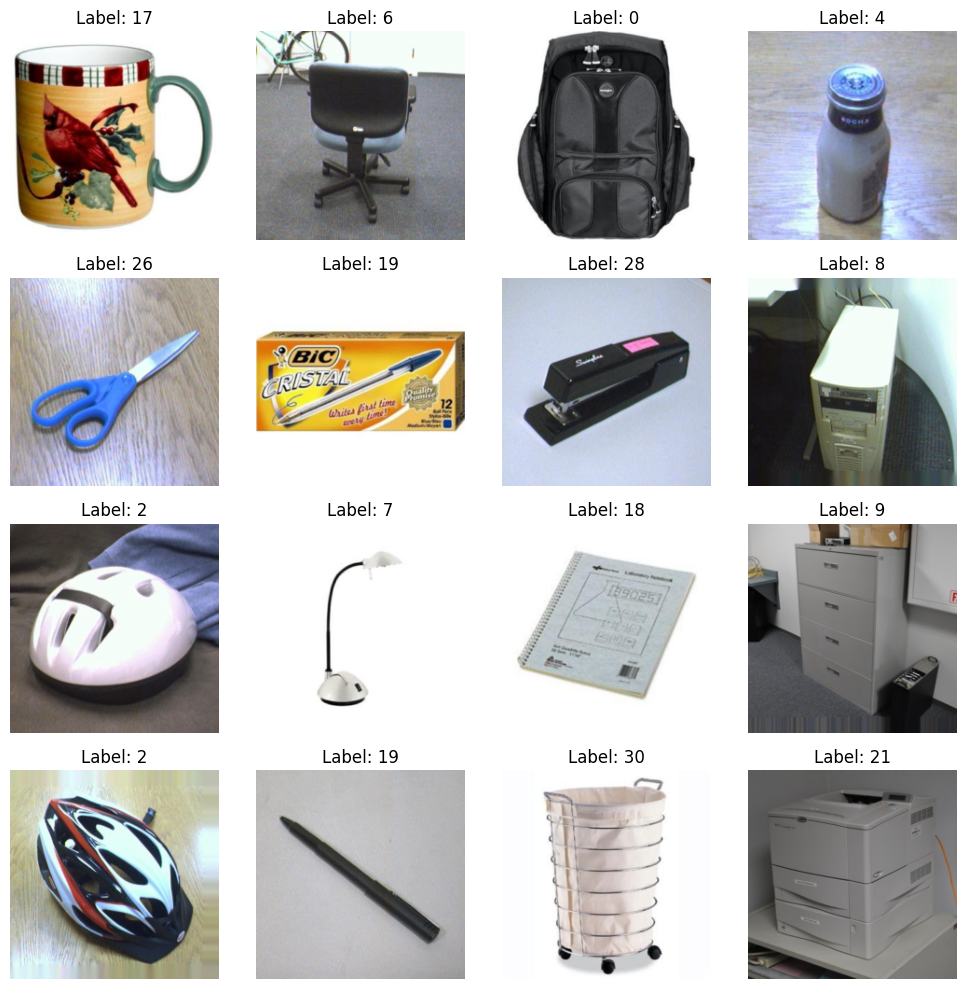

In [16]:
from torch.utils.data import DataLoader, random_split
image_size = 224
batch_size = 32
EPOCHS = 30
# Step 3: Load and preprocess the Office-31 dataset
# Data Augmentation
train_transforms = transform.Compose([
    transform.Resize((224, 224)),  # Resize the input images to 224x224
    transform.ToTensor(),  # Convert images to tensors
    # Normalize using ImageNet mean and std
    transform.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transform.Compose([
    transform.Resize((224, 224)),  # Resize the input images to 224x224
    transform.ToTensor(),  # Convert images to tensors
    # Normalize using ImageNet mean and std
    transform.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Path to the Office-31 dataset (which contains 'amazon', 'dslr', 'webcam' directories)
data_dir = './Office-31/'  # Update to your dataset path

# Load datasets from each domain and combine them
amazon_dataset = datasets.ImageFolder(os.path.join(
    data_dir, 'amazon'), transform=train_transforms)
webcam_dataset = datasets.ImageFolder(os.path.join(
    data_dir, 'webcam'), transform=train_transforms)
dslr_dataset = datasets.ImageFolder(os.path.join(
    data_dir, 'dslr'), transform=train_transforms)

# Option 1: Combine all domains into a single dataset (optional)
combined_dataset = torch.utils.data.ConcatDataset(
    [amazon_dataset, webcam_dataset, dslr_dataset])

# Calculate the split sizes for training and testing (80% train, 20% test)
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size

# Split dataset into train and test sets
train_dataset, test_dataset = torch.utils.data.random_split(
    combined_dataset, [train_size, test_size])

# Create DataLoader for both training and testing sets
train_loader = DataLoader(train_dataset, batch_size=32,
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32,
                         shuffle=False, num_workers=2)

# Get a batch of images and labels from the training DataLoader
images, labels = next(iter(train_loader))

# Create a 4x4 figure (to plot 16 images)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

# Plot images
for i in range(16):  # Plot the first 16 images from the batch
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Convert from PyTorch tensor to numpy array for plotting
    image = images[i].permute(1, 2, 0)  # Permute to (H, W, C) for Matplotlib

    # Undo normalization (if you used mean and std normalization)
    image = image * torch.tensor([0.229, 0.224, 0.225]) + \
        torch.tensor([0.485, 0.456, 0.406])
    image = image.clamp(0, 1)  # Ensure values are within [0, 1] for display

    ax.imshow(image)
    # Convert label to scalar for display
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
import seaborn as sns
def plot_confusion_matrix(conf_matrix):
  """Plots a confusion matrix using Seaborn.

  Args:
    conf_matrix: The confusion matrix to plot.
  """
  plt.figure(figsize=(10, 7))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

In [18]:
# Step 4: Load MobileNetV3-small Pretrained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ModifiedMobileNetV3Small(nn.Module):
    def __init__(self):
        super(ModifiedMobileNetV3Small, self).__init__()
        self.model = mobilenet_v3_small(pretrained=True)

        self.model.classifier[3] = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(
                in_features=self.model.classifier[3].in_features, out_features=31, bias=True)
        )

    def forward(self, x):
        return self.model(x)

# Load the model
model_MBV3small = ModifiedMobileNetV3Small().to(device)

model_MBV3small = model_MBV3small.to(device)

c:\Users\Kolawat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kolawat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
from torchsummary import summary
from fvcore.nn import FlopCountAnalysis

# Model Summary
summary(model_MBV3small, input_size=(3, 224, 224))

# FLOPs Calculation
flops = FlopCountAnalysis(
    model_MBV3small, torch.randn(1, 3, 224, 224).to(device))
print(f"FLOPs: {flops.total()}")

# Number of parameters
num_params = sum(p.numel() for p in model_MBV3small.parameters())
print(f"Total Parameters: {num_params}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

Unsupported operator aten::add_ encountered 40 time(s)
Unsupported operator aten::hardswish_ encountered 19 time(s)
Unsupported operator aten::hardsigmoid encountered 9 time(s)
Unsupported operator aten::mul encountered 9 time(s)
Unsupported operator aten::dropout_ encountered 2 time(s)


FLOPs: 62895584
Total Parameters: 1549631


In [20]:

# Step 6: Define Training and Evaluation Loop
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, normalized_mutual_info_score as nmi_score, adjusted_rand_score as ri_score
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_all_labels = []  # Store all labels across batches
        val_all_preds = []  # Store all predictions across batches

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)

                val_all_labels.extend(labels.cpu().numpy())
                val_all_preds.extend(preds.cpu().numpy())

        val_loss = val_running_loss / len(test_loader.dataset)
        val_acc = val_running_corrects.double() / len(test_loader.dataset)

        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Calculate metrics after all epochs
    
    class_report = classification_report(val_all_labels, val_all_preds)
    acc = val_running_corrects.double() / len(test_loader.dataset)
    loss = val_running_loss / len(test_loader.dataset)
    precision = precision_score(val_all_labels, val_all_preds, average='weighted')
    recall = recall_score(val_all_labels, val_all_preds, average='weighted')
    f1 = f1_score(val_all_labels, val_all_preds, average='weighted')
    
    conf_matrix = confusion_matrix(val_all_labels, val_all_preds)
    nmi = nmi_score(val_all_labels, val_all_preds)
    ri = ri_score(val_all_labels, val_all_preds)    

    print(f'Accuracy: {acc:.4f}')
    print(f'Loss: {loss:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'NMI Score: {nmi:.4f}')
    print(f'RI Score: {ri:.4f}')
    print(class_report)
    plot_confusion_matrix(conf_matrix)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

def compute_and_plot_a_distance_and_tsne(model, train_loader, test_loader):
    # def compute_a_distance(source_features, target_features):
    #     """Compute the A-distance between source and target features."""
    #     X = np.vstack((source_features, target_features))
    #     y = np.hstack((np.zeros(len(source_features)), np.ones(len(target_features))))

    #     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    #     clf = SVC(kernel='linear')
    #     clf.fit(X_train, y_train)
    #     y_pred = clf.predict(X_test)
    #     error = np.mean(y_pred != y_test)
    #     a_distance = 2 * (1 - 2 * error)
    #     return a_distance

    def extract_features(model, loader):
        model.eval()
        features = []
        labels = []

        with torch.no_grad():
            for inputs, lbls in loader:
                inputs = inputs.to(device)
                outputs = model.model.features(inputs)
                features.append(outputs.cpu().numpy())
                labels.append(lbls.cpu().numpy())

        features = np.concatenate(features, axis=0)
        labels = np.concatenate(labels, axis=0)
        features = features.reshape(features.shape[0], -1)
        return features, labels
    def compute_a_distance(source_features, target_features):
        """Compute the A-distance between source and target features using a simpler method."""
        source_mean = np.mean(source_features, axis=0)
        target_mean = np.mean(target_features, axis=0)
        distance = np.linalg.norm(source_mean - target_mean)
        return distance

    def plot_tsne_combined(source_features, source_labels, target_features, target_labels):
        tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
        combined_features = np.vstack((source_features, target_features))
        tsne_results = tsne.fit_transform(combined_features)

        plt.figure(figsize=(10, 7))
        sns.scatterplot(
            x=tsne_results[:len(source_features), 0], y=tsne_results[:len(source_features), 1], hue=source_labels, palette='tab10', marker='o'
        )
        sns.scatterplot(
            x=tsne_results[len(source_features):, 0], y=tsne_results[len(source_features):, 1], hue=target_labels, palette='tab10', marker='x'
        )
        plt.title('t-SNE of Source and Target Features')
        plt.legend()
        plt.show()

    # Extract features for source and target datasets
    source_features, source_labels = extract_features(model, train_loader)
    target_features, target_labels = extract_features(model, test_loader)

    # Compute A-distance
    a_distance = compute_a_distance(source_features, target_features)
    print(f"A-distance: {a_distance:.4f}")

    # Plot t-SNE
    plot_tsne_combined(source_features, source_labels, target_features, target_labels)

# Example usage:
# compute_and_plot_a_distance_and_tsne(trained_student_model, train_loader, test_loader)


def plot_performance(train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [21]:
# Step 5: Set up loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()

# Optimizer and scheduler for MobileNetV3-small
optimizer_small = optim.Adam(model_MBV3small.parameters(), lr=0.0001)
scheduler_small = optim.lr_scheduler.StepLR(
    optimizer_small, step_size=7, gamma=0.1)


Epoch 1/30
----------


C:\Users\Kolawat\AppData\Local\Temp\ipykernel_13952\3681045805.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 2.9609 Acc: 0.2503
Validation Loss: 2.2298 Acc: 0.5462
Epoch 2/30
----------
Training Loss: 1.7152 Acc: 0.6080
Validation Loss: 1.2422 Acc: 0.7165
Epoch 3/30
----------
Training Loss: 1.0327 Acc: 0.7488
Validation Loss: 0.8650 Acc: 0.7944
Epoch 4/30
----------
Training Loss: 0.7246 Acc: 0.8209
Validation Loss: 0.7255 Acc: 0.8114
Epoch 5/30
----------
Training Loss: 0.5533 Acc: 0.8601
Validation Loss: 0.6600 Acc: 0.8297
Epoch 6/30
----------
Training Loss: 0.4481 Acc: 0.8859
Validation Loss: 0.6063 Acc: 0.8321
Epoch 7/30
----------
Training Loss: 0.3634 Acc: 0.9075
Validation Loss: 0.5805 Acc: 0.8370
Epoch 8/30
----------
Training Loss: 0.2839 Acc: 0.9264
Validation Loss: 0.5622 Acc: 0.8455
Epoch 9/30
----------
Training Loss: 0.2672 Acc: 0.9304
Validation Loss: 0.5556 Acc: 0.8467
Epoch 10/30
----------
Training Loss: 0.2570 Acc: 0.9407
Validation Loss: 0.5537 Acc: 0.8479
Epoch 11/30
----------
Training Loss: 0.2525 Acc: 0.9398
Validation Loss: 0.5513 Acc: 0.8516
Epoch 12

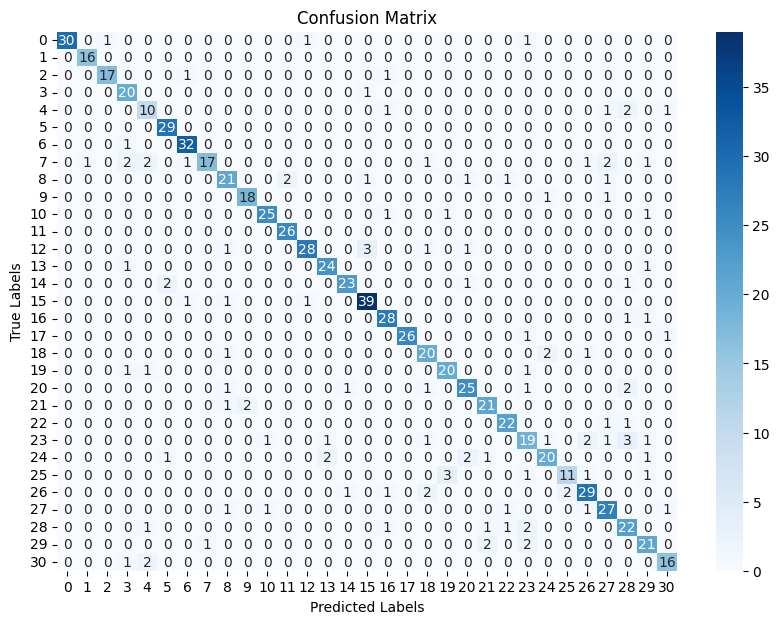

A-distance: 8.2859


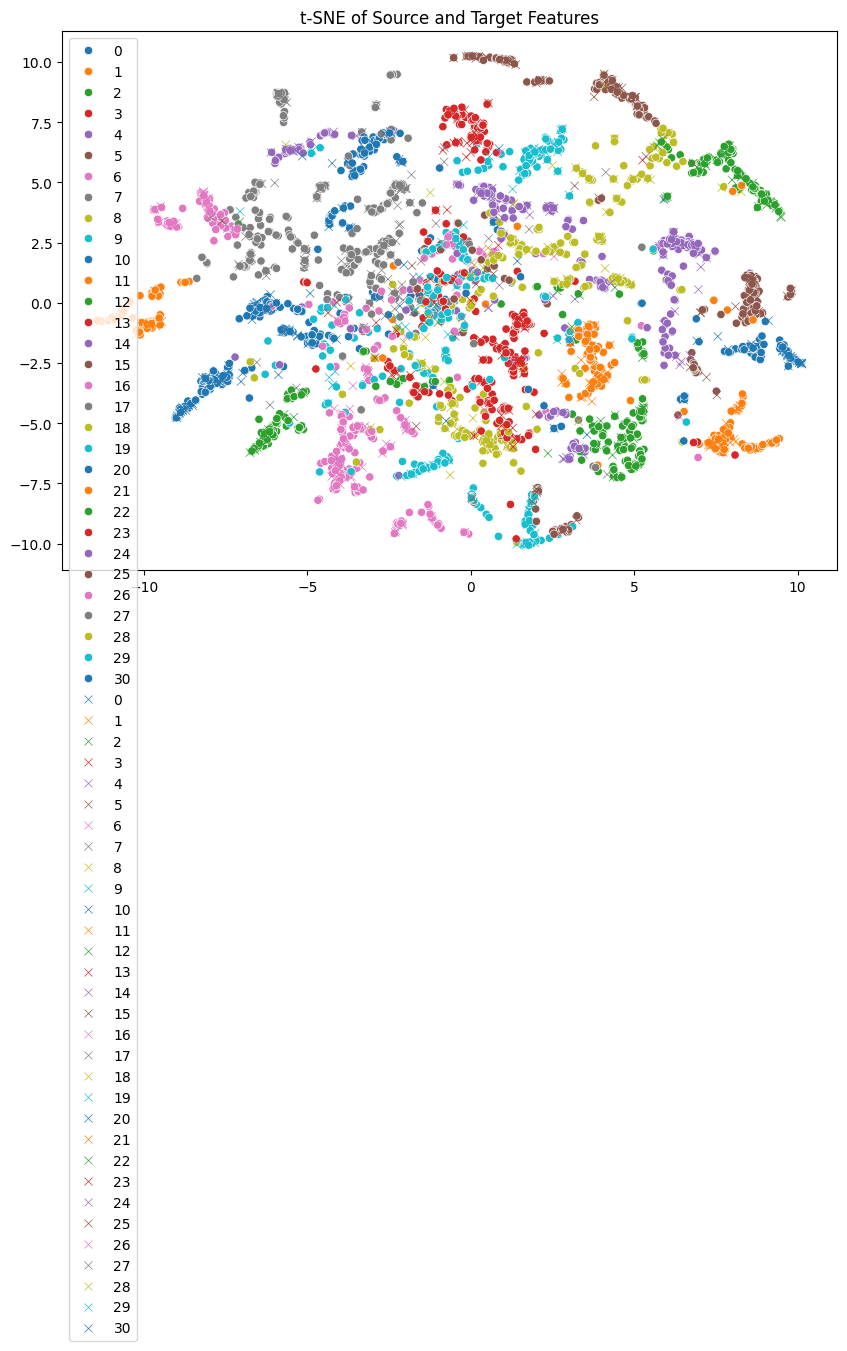

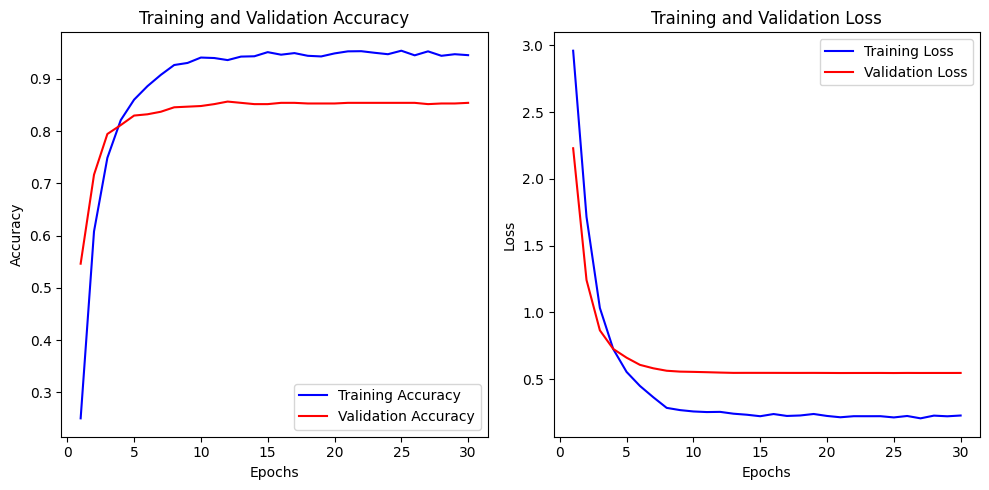

In [22]:
# Step 7: Train the models
trained_model_small, train_acc_history_model_MBV3small, val_acc_history_model_MBV3small, train_loss_history_model_MBV3small, val_loss_history_model_MBV3small = train_model(
    model_MBV3small, criterion, optimizer_small, scheduler_small, num_epochs=EPOCHS)
compute_and_plot_a_distance_and_tsne(trained_model_small, train_loader, test_loader)
plot_performance(train_acc_history_model_MBV3small, val_acc_history_model_MBV3small,
                 train_loss_history_model_MBV3small, val_loss_history_model_MBV3small)
torch.save(trained_model_small.state_dict(),
           'cp/mobilenetv3_small_office31_labeled.pth')

### Transfer Learning

Epoch 1/30
----------


C:\Users\Kolawat\AppData\Local\Temp\ipykernel_13952\3681045805.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 1.7371 Acc: 0.5964
Validation Loss: 0.8791 Acc: 0.7822
Epoch 2/30
----------
Training Loss: 0.5136 Acc: 0.8905
Validation Loss: 0.6543 Acc: 0.8297
Epoch 3/30
----------
Training Loss: 0.3194 Acc: 0.9252
Validation Loss: 0.5929 Acc: 0.8212
Epoch 4/30
----------
Training Loss: 0.2144 Acc: 0.9532
Validation Loss: 0.5786 Acc: 0.8309
Epoch 5/30
----------
Training Loss: 0.1545 Acc: 0.9638
Validation Loss: 0.5810 Acc: 0.8370
Epoch 6/30
----------
Training Loss: 0.1121 Acc: 0.9805
Validation Loss: 0.5871 Acc: 0.8418
Epoch 7/30
----------
Training Loss: 0.0840 Acc: 0.9830
Validation Loss: 0.5875 Acc: 0.8467
Epoch 8/30
----------
Training Loss: 0.0613 Acc: 0.9933
Validation Loss: 0.5701 Acc: 0.8516
Epoch 9/30
----------
Training Loss: 0.0585 Acc: 0.9906
Validation Loss: 0.5660 Acc: 0.8504
Epoch 10/30
----------
Training Loss: 0.0530 Acc: 0.9918
Validation Loss: 0.5641 Acc: 0.8540
Epoch 11/30
----------
Training Loss: 0.0536 Acc: 0.9918
Validation Loss: 0.5647 Acc: 0.8589
Epoch 12

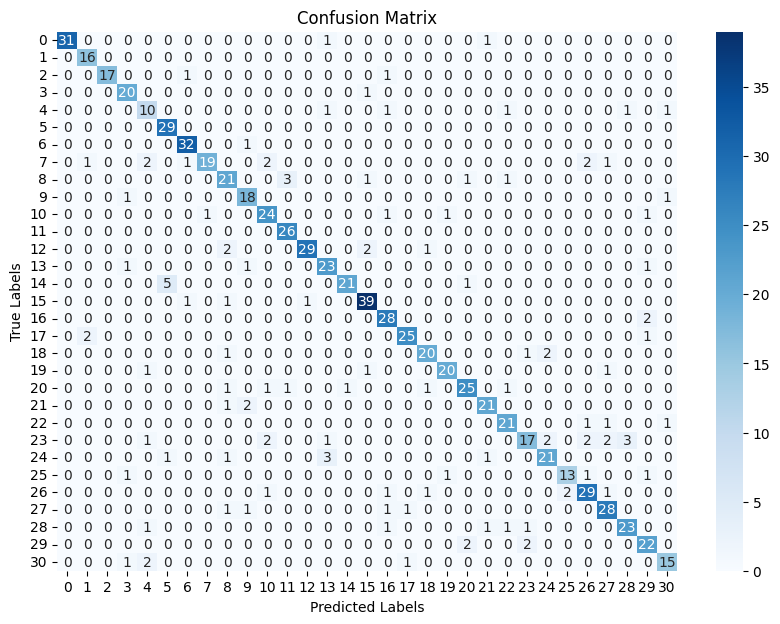

A-distance: 8.5175


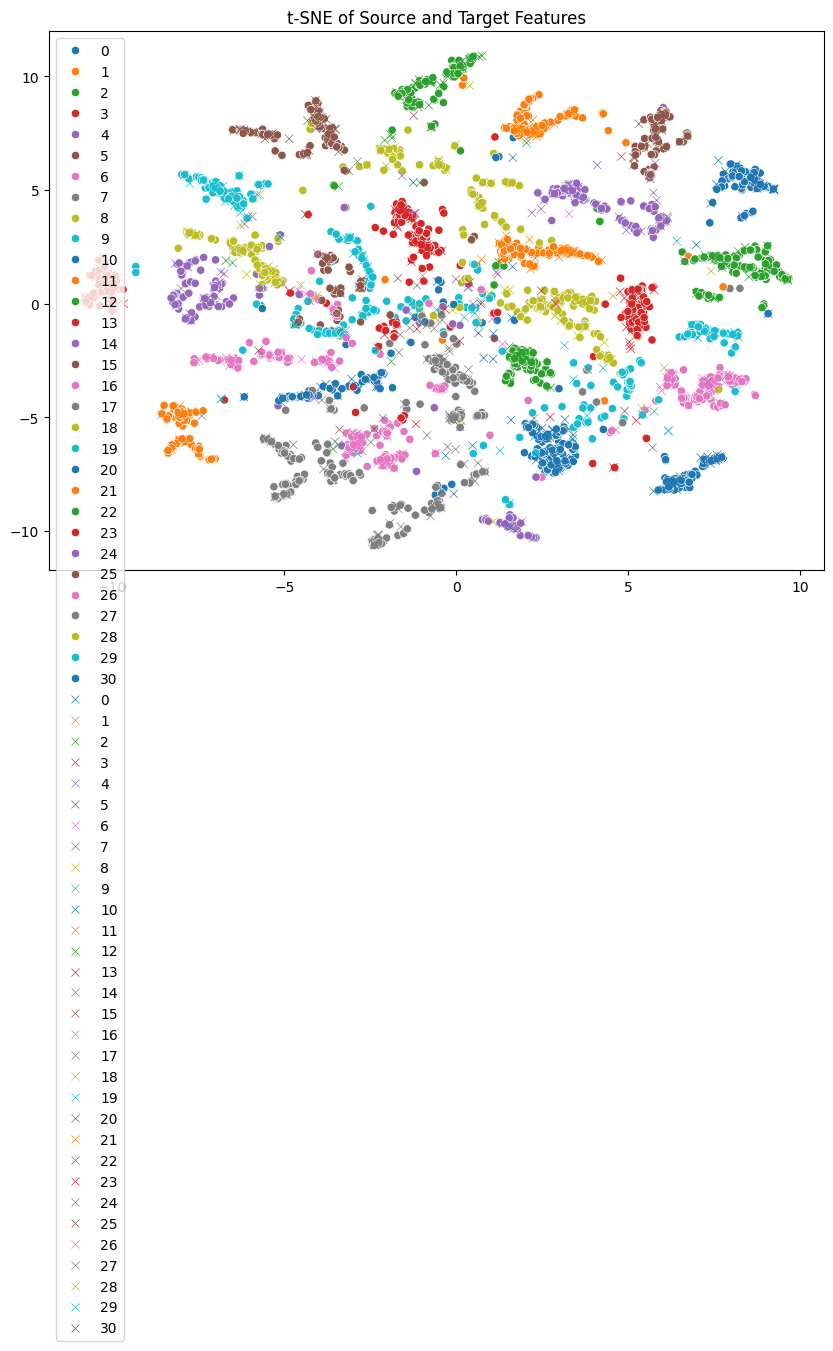

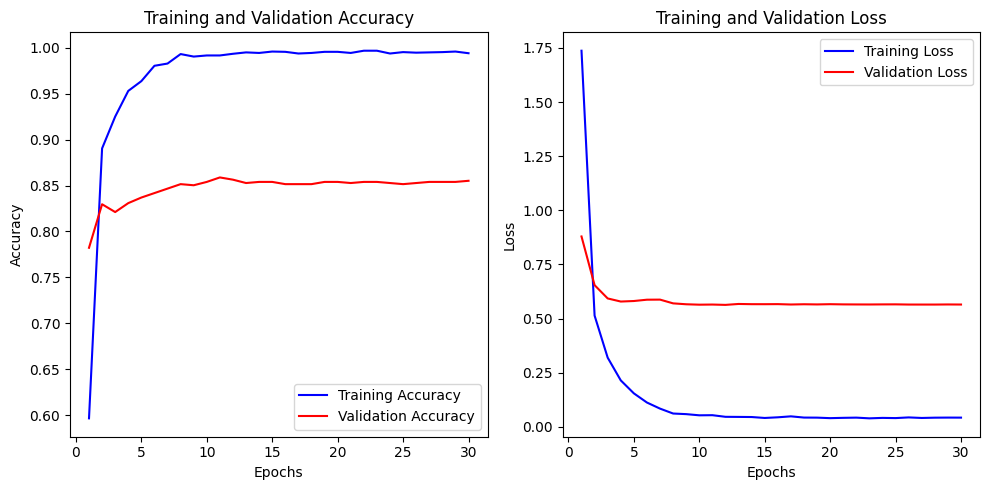

In [23]:
trained_model_small.model.classifier[3] = nn.Linear(in_features=trained_model_small.model.classifier[3][1].in_features, out_features=31, bias=True)
net = trained_model_small.to(device)

# Fine-tune more layers
for param in net.parameters():
    param.requires_grad = True
    
fine_tune_optimizer = optim.Adam(net.parameters(), lr=0.0001)
fine_tune_scheduler = optim.lr_scheduler.StepLR(
    fine_tune_optimizer, step_size=7, gamma=0.1)

# Ensure model and inputs are float32
net = net.float()
trained_model_finetuned, train_acc_history_model_finetuned, val_acc_history_model_finetuned, train_loss_history_model_finetuned, val_loss_history_model_finetuned = train_model(
    net, criterion, fine_tune_optimizer, fine_tune_scheduler, num_epochs=EPOCHS)
compute_and_plot_a_distance_and_tsne(trained_model_finetuned, train_loader, test_loader)
plot_performance(train_acc_history_model_finetuned, val_acc_history_model_finetuned,
                 train_loss_history_model_finetuned, val_loss_history_model_finetuned)
torch.save(trained_model_finetuned.state_dict(), 'cp/mobilenetv3_small_office31_finetuned.pth')

### Adaptation

In [24]:
import torch.nn.utils.prune as prune
class CORAL(nn.Module):
    def __init__(self):
        super(CORAL, self).__init__()

    def forward(self, source, target):
        d = source.size(1)
        source_coral = self._coral_loss(source, target, d)
        return source_coral

    def _coral_loss(self, source, target, d):
        source_cov = self._compute_covariance(source)
        target_cov = self._compute_covariance(target)
        loss = torch.mean(torch.pow(source_cov - target_cov, 2)) / (4 * d * d)
        return loss

    def _compute_covariance(self, x):
        n = x.size(0)
        x = x - torch.mean(x, dim=0, keepdim=True)
        cov = torch.mm(x.t(), x) / (n - 1)
        return cov

coral_loss = CORAL()

c:\Users\Kolawat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kolawat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Kolawat\AppData\Local\Temp\ipykernel_13952\405021493.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30, Loss: 3.0255
Epoch 2/30, Loss: 1.8880
Epoch 3/30, Loss: 1.2220
Epoch 4/30, Loss: 0.9132
Epoch 5/30, Loss: 0.7286
Epoch 6/30, Loss: 0.5906
Epoch 7/30, Loss: 0.4742
Epoch 8/30, Loss: 0.3867
Epoch 9/30, Loss: 0.3844
Epoch 10/30, Loss: 0.3755
Epoch 11/30, Loss: 0.3613
Epoch 12/30, Loss: 0.3568
Epoch 13/30, Loss: 0.3453
Epoch 14/30, Loss: 0.3427
Epoch 15/30, Loss: 0.3392
Epoch 16/30, Loss: 0.3183
Epoch 17/30, Loss: 0.3267
Epoch 18/30, Loss: 0.3289
Epoch 19/30, Loss: 0.3321
Epoch 20/30, Loss: 0.3222
Epoch 21/30, Loss: 0.3237
Epoch 22/30, Loss: 0.3254
Epoch 23/30, Loss: 0.3221
Epoch 24/30, Loss: 0.3209
Epoch 25/30, Loss: 0.3154
Epoch 26/30, Loss: 0.3289
Epoch 27/30, Loss: 0.3161
Epoch 28/30, Loss: 0.3336
Epoch 29/30, Loss: 0.3347
Epoch 30/30, Loss: 0.3238
Epoch 1/30, Loss: 3.3769
Epoch 2/30, Loss: 2.9671
Epoch 3/30, Loss: 2.5857
Epoch 4/30, Loss: 2.1441
Epoch 5/30, Loss: 1.7098
Epoch 6/30, Loss: 1.3860
Epoch 7/30, Loss: 1.0460
Epoch 8/30, Loss: 0.8610
Epoch 9/30, Loss: 0.8680
Epoc

C:\Users\Kolawat\AppData\Local\Temp\ipykernel_13952\405021493.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30, Loss: 2.4051
Epoch 2/30, Loss: 1.3261
Epoch 3/30, Loss: 1.0698
Epoch 4/30, Loss: 0.9623
Epoch 5/30, Loss: 0.9038
Epoch 6/30, Loss: 0.8527
Epoch 7/30, Loss: 0.8253
Epoch 8/30, Loss: 0.7989
Epoch 9/30, Loss: 0.7738
Epoch 10/30, Loss: 0.7593
Epoch 11/30, Loss: 0.7459
Epoch 12/30, Loss: 0.7296
Epoch 13/30, Loss: 0.7266
Epoch 14/30, Loss: 0.7150
Epoch 15/30, Loss: 0.7089
Epoch 16/30, Loss: 0.7027
Epoch 17/30, Loss: 0.6969
Epoch 18/30, Loss: 0.6869
Epoch 19/30, Loss: 0.6861
Epoch 20/30, Loss: 0.6805
Epoch 21/30, Loss: 0.6808
Epoch 22/30, Loss: 0.6777
Epoch 23/30, Loss: 0.6756
Epoch 24/30, Loss: 0.6720
Epoch 25/30, Loss: 0.6684
Epoch 26/30, Loss: 0.6648
Epoch 27/30, Loss: 0.6621
Epoch 28/30, Loss: 0.6625
Epoch 29/30, Loss: 0.6585
Epoch 30/30, Loss: 0.6585
Epoch 1/30
----------


C:\Users\Kolawat\AppData\Local\Temp\ipykernel_13952\3681045805.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.1815 Acc: 0.9994
Validation Loss: 0.5429 Acc: 0.8820
Epoch 2/30
----------
Training Loss: 0.1828 Acc: 0.9994
Validation Loss: 0.5416 Acc: 0.8832
Epoch 3/30
----------
Training Loss: 0.1845 Acc: 1.0000
Validation Loss: 0.5412 Acc: 0.8844
Epoch 4/30
----------
Training Loss: 0.1842 Acc: 0.9991
Validation Loss: 0.5409 Acc: 0.8856
Epoch 5/30
----------
Training Loss: 0.1845 Acc: 0.9997
Validation Loss: 0.5409 Acc: 0.8881
Epoch 6/30
----------
Training Loss: 0.1791 Acc: 0.9991
Validation Loss: 0.5408 Acc: 0.8832
Epoch 7/30
----------
Training Loss: 0.1865 Acc: 0.9997
Validation Loss: 0.5411 Acc: 0.8856
Epoch 8/30
----------
Training Loss: 0.1810 Acc: 0.9997
Validation Loss: 0.5405 Acc: 0.8856
Epoch 9/30
----------
Training Loss: 0.1834 Acc: 1.0000
Validation Loss: 0.5400 Acc: 0.8881
Epoch 10/30
----------
Training Loss: 0.1774 Acc: 0.9997
Validation Loss: 0.5409 Acc: 0.8869
Epoch 11/30
----------
Training Loss: 0.1874 Acc: 1.0000
Validation Loss: 0.5419 Acc: 0.8869
Epoch 12

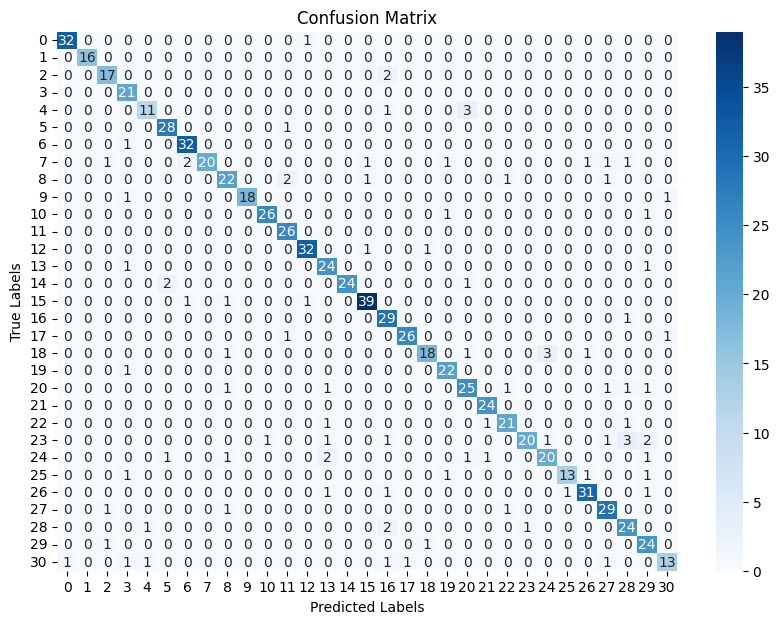

A-distance: 7.9523


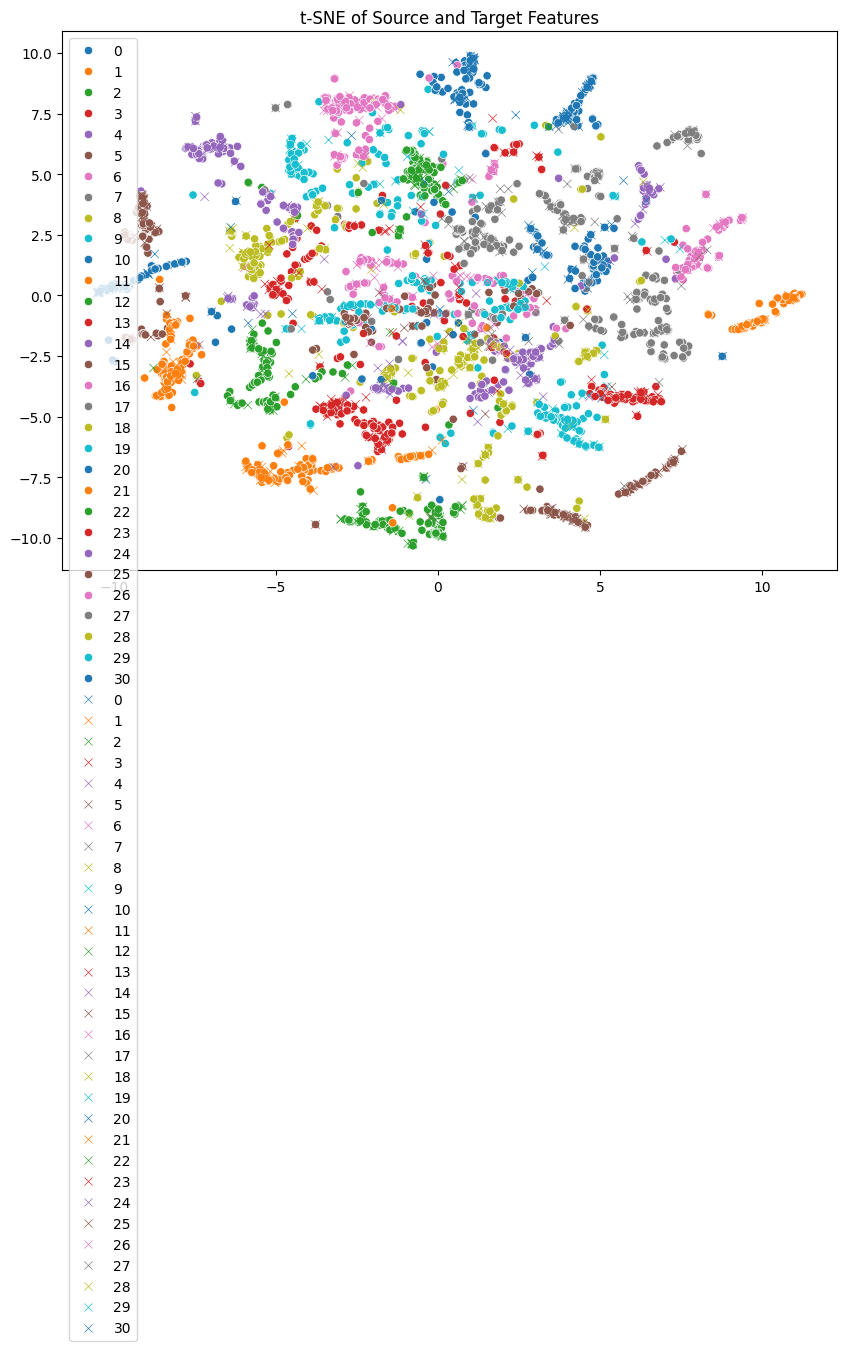

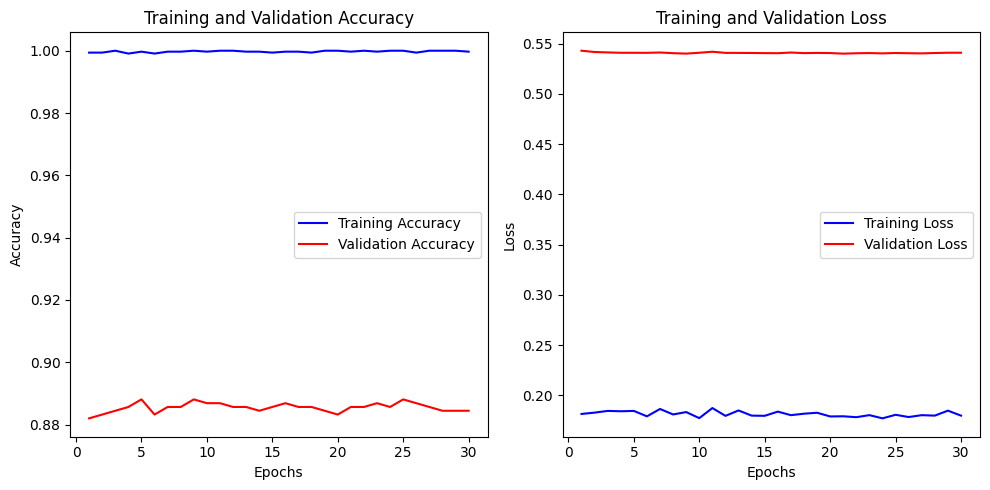

In [25]:
# Define a function to train a teacher model on a specific dataset
def train_teacher_model(model, dataset, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in DataLoader(dataset, batch_size=batch_size, shuffle=True):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        scheduler.step()
        epoch_loss = running_loss / len(dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    return model


# Create and train teacher models for amazon, dslr, and webcam datasets
teacher_model_amazon = ModifiedMobileNetV3Small().to(device)
teacher_model_dslr = ModifiedMobileNetV3Small().to(device)
teacher_model_webcam = ModifiedMobileNetV3Small().to(device)

optimizer_amazon = optim.Adam(teacher_model_amazon.parameters(), lr=0.0001)
scheduler_amazon = optim.lr_scheduler.StepLR(optimizer_amazon, step_size=7, gamma=0.1)

optimizer_dslr = optim.Adam(teacher_model_dslr.parameters(), lr=0.0001)
scheduler_dslr = optim.lr_scheduler.StepLR(optimizer_dslr, step_size=7, gamma=0.1)

optimizer_webcam = optim.Adam(teacher_model_webcam.parameters(), lr=0.0001)
scheduler_webcam = optim.lr_scheduler.StepLR(optimizer_webcam, step_size=7, gamma=0.1)

teacher_model_amazon = train_teacher_model(teacher_model_amazon, amazon_dataset, criterion, optimizer_amazon, scheduler_amazon)
teacher_model_dslr = train_teacher_model(teacher_model_dslr, dslr_dataset, criterion, optimizer_dslr, scheduler_dslr)
teacher_model_webcam = train_teacher_model(teacher_model_webcam, webcam_dataset, criterion, optimizer_webcam, scheduler_webcam)

# Knowledge Distillation with multiple teachers
class MultiTeacherDistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.5):
        super(MultiTeacherDistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_outputs, teacher_outputs_list, labels):
        distillation_loss = 0
        for teacher_outputs in teacher_outputs_list:
            soft_targets = F.softmax(teacher_outputs / self.temperature, dim=1)
            soft_student_outputs = F.log_softmax(student_outputs / self.temperature, dim=1)
            distillation_loss += F.kl_div(soft_student_outputs, soft_targets, reduction='batchmean') * (self.temperature ** 2)
        distillation_loss /= len(teacher_outputs_list)
        student_loss = self.criterion(student_outputs, labels)
        return self.alpha * student_loss + (1 - self.alpha) * distillation_loss

# Training the student model with multiple teachers
def train_student_model_with_teachers(student_model, teacher_models, criterion, optimizer, num_epochs=EPOCHS):
    student_model.train()
    for teacher_model in teacher_models:
        teacher_model.eval()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                student_outputs = student_model(inputs)
                teacher_outputs_list = [teacher_model(inputs) for teacher_model in teacher_models]
                loss = criterion(student_outputs, teacher_outputs_list, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return student_model


class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.model = mobilenet_v3_small(pretrained=True)
        self.model.classifier[3] = nn.Linear(
            in_features=self.model.classifier[3].in_features, out_features=31, bias=True)

    def forward(self, x):
        return self.model(x)

student_model = StudentModel().to(device)

# Set up loss function and optimizer for the student model
multi_teacher_distillation_criterion = MultiTeacherDistillationLoss(temperature=3.0, alpha=0.5)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.0001)

# Train the student model with multiple teachers
trained_student_model = train_student_model_with_teachers(student_model, [teacher_model_amazon, teacher_model_dslr, teacher_model_webcam], multi_teacher_distillation_criterion, student_optimizer, num_epochs=EPOCHS)
adapted_student_model, train_acc_history_student, val_acc_history_student, train_loss_history_student, val_loss_history_student = train_model(
    trained_student_model, criterion, optimizer_small, scheduler_small, num_epochs=EPOCHS)
compute_and_plot_a_distance_and_tsne(adapted_student_model, train_loader, test_loader)
plot_performance(train_acc_history_student, val_acc_history_student,
                 train_loss_history_student, val_loss_history_student)

# Save the student model
torch.save(trained_student_model.state_dict(), 'cp/mobilenetv3_small_office31_multi_teacher_compressed.pth')

### Model Compression

c:\Users\Kolawat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Kolawat\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Kolawat\AppData\Local\Temp\ipykernel_13952\1905911650.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/30, Loss: 1.6215
Epoch 2/30, Loss: 0.9219
Epoch 3/30, Loss: 0.7305
Epoch 4/30, Loss: 0.6431
Epoch 5/30, Loss: 0.5846
Epoch 6/30, Loss: 0.5463
Epoch 7/30, Loss: 0.5129
Epoch 8/30, Loss: 0.4894
Epoch 9/30, Loss: 0.4725
Epoch 10/30, Loss: 0.4525
Epoch 11/30, Loss: 0.4353
Epoch 12/30, Loss: 0.4252
Epoch 13/30, Loss: 0.4160
Epoch 14/30, Loss: 0.4063
Epoch 15/30, Loss: 0.3992
Epoch 16/30, Loss: 0.3952
Epoch 17/30, Loss: 0.3861
Epoch 18/30, Loss: 0.3810
Epoch 19/30, Loss: 0.3782
Epoch 20/30, Loss: 0.3729
Epoch 21/30, Loss: 0.3717
Epoch 22/30, Loss: 0.3643
Epoch 23/30, Loss: 0.3628
Epoch 24/30, Loss: 0.3630
Epoch 25/30, Loss: 0.3580
Epoch 26/30, Loss: 0.3555
Epoch 27/30, Loss: 0.3520
Epoch 28/30, Loss: 0.3486
Epoch 29/30, Loss: 0.3474
Epoch 30/30, Loss: 0.3462
Epoch 1/30
----------


C:\Users\Kolawat\AppData\Local\Temp\ipykernel_13952\3681045805.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.3180 Acc: 1.0000
Validation Loss: 0.7593 Acc: 0.8479
Epoch 2/30
----------
Training Loss: 0.3205 Acc: 1.0000
Validation Loss: 0.7575 Acc: 0.8491
Epoch 3/30
----------
Training Loss: 0.3161 Acc: 0.9994
Validation Loss: 0.7574 Acc: 0.8516
Epoch 4/30
----------
Training Loss: 0.3191 Acc: 1.0000
Validation Loss: 0.7564 Acc: 0.8516
Epoch 5/30
----------
Training Loss: 0.3168 Acc: 1.0000
Validation Loss: 0.7571 Acc: 0.8516
Epoch 6/30
----------
Training Loss: 0.3251 Acc: 1.0000
Validation Loss: 0.7576 Acc: 0.8528
Epoch 7/30
----------
Training Loss: 0.3213 Acc: 1.0000
Validation Loss: 0.7582 Acc: 0.8528
Epoch 8/30
----------
Training Loss: 0.3186 Acc: 0.9997
Validation Loss: 0.7578 Acc: 0.8528
Epoch 9/30
----------
Training Loss: 0.3095 Acc: 1.0000
Validation Loss: 0.7583 Acc: 0.8528
Epoch 10/30
----------
Training Loss: 0.3206 Acc: 1.0000
Validation Loss: 0.7587 Acc: 0.8504
Epoch 11/30
----------
Training Loss: 0.3158 Acc: 1.0000
Validation Loss: 0.7590 Acc: 0.8504
Epoch 12

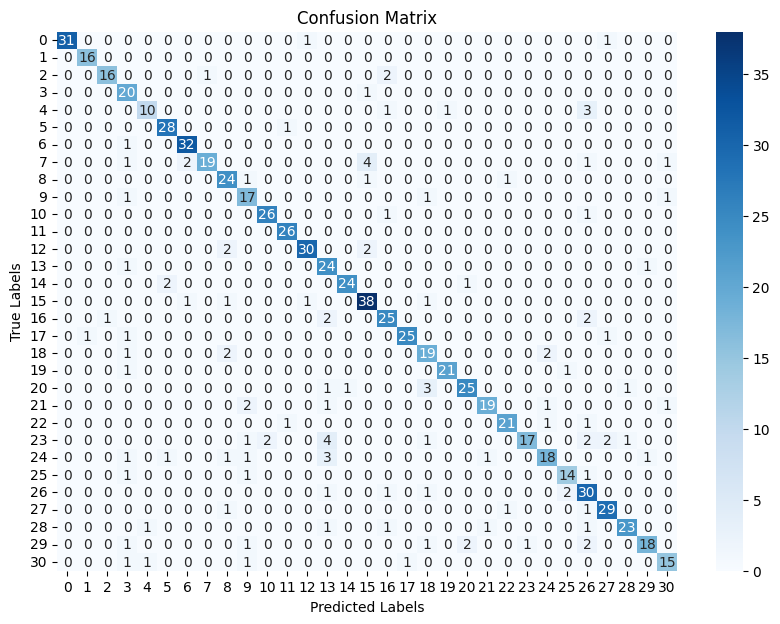

A-distance: 7.9820


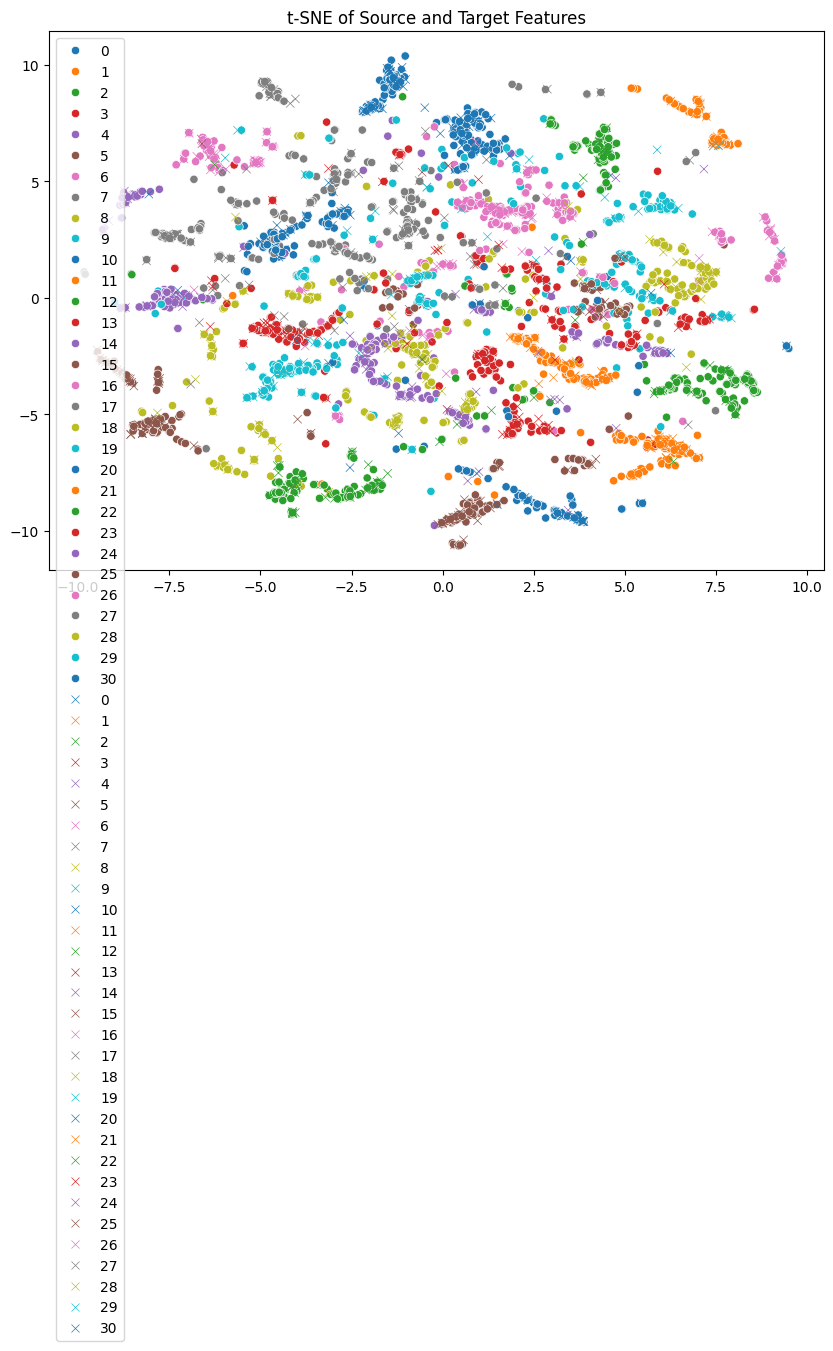

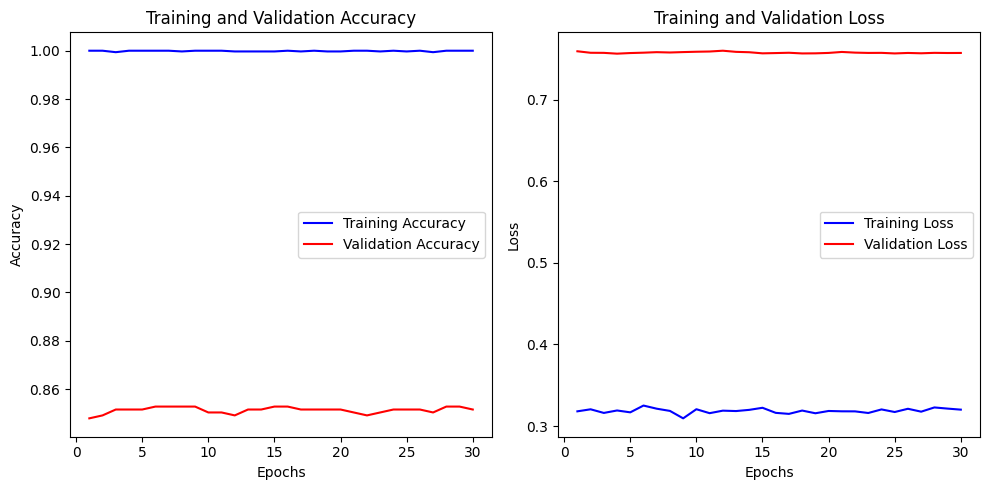

In [26]:
import torch.nn.utils.prune as prune

# Pruning the model
def prune_model(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.remove(module, 'weight')
    return model

# Prune the trained model
pruned_model = prune_model(trained_student_model, amount=0.3)

# Define a smaller student model
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.model = mobilenet_v3_small(pretrained=True)
        self.model.classifier[3] = nn.Linear(
            in_features=self.model.classifier[3].in_features, out_features=31, bias=True)

    def forward(self, x):
        return self.model(x)

student_model = StudentModel().to('cuda')

# Knowledge Distillation Loss
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, student_outputs, teacher_outputs, labels):
        soft_targets = F.softmax(teacher_outputs / self.temperature, dim=1)
        soft_student_outputs = F.log_softmax(student_outputs / self.temperature, dim=1)
        distillation_loss = F.kl_div(soft_student_outputs, soft_targets, reduction='batchmean') * (self.temperature ** 2)
        student_loss = self.criterion(student_outputs, labels)
        return self.alpha * student_loss + (1 - self.alpha) * distillation_loss

# Training the student model with KD
def train_student_model(student_model, teacher_model, criterion, optimizer, num_epochs=EPOCHS):
    student_model.train()
    teacher_model.eval()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                student_outputs = student_model(inputs)
                teacher_outputs = teacher_model(inputs)
                loss = criterion(student_outputs, teacher_outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return student_model

# Set up loss function and optimizer for the student model
distillation_criterion = DistillationLoss(temperature=3.0, alpha=0.5)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.0001)

# Train the student model
# Add weight mask to Conv2d layers
def add_weight_mask(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=0.0)  # Initialize mask with no pruning
    return model

# Add weight mask to the pruned model
pruned_model_with_mask = add_weight_mask(pruned_model)

# Move pruned model to CPU
pruned_model_with_mask = pruned_model_with_mask.to('cuda')

# Train the student model
trained_student_model = train_student_model(student_model, pruned_model_with_mask, distillation_criterion, student_optimizer, num_epochs=EPOCHS)
trained_compress_model, train_acc_history_compress, val_acc_history_compress, train_loss_history_compress, val_loss_history_compress = train_model(
    trained_student_model, criterion, optimizer_small, scheduler_small, num_epochs=EPOCHS)
compute_and_plot_a_distance_and_tsne(trained_compress_model, train_loader, test_loader)
plot_performance(train_acc_history_compress, val_acc_history_compress,
                 train_loss_history_compress, val_loss_history_compress)

# Save the compressed model
torch.save(trained_student_model.state_dict(), 'cp/mobilenetv3_small_office31_compressed.pth')


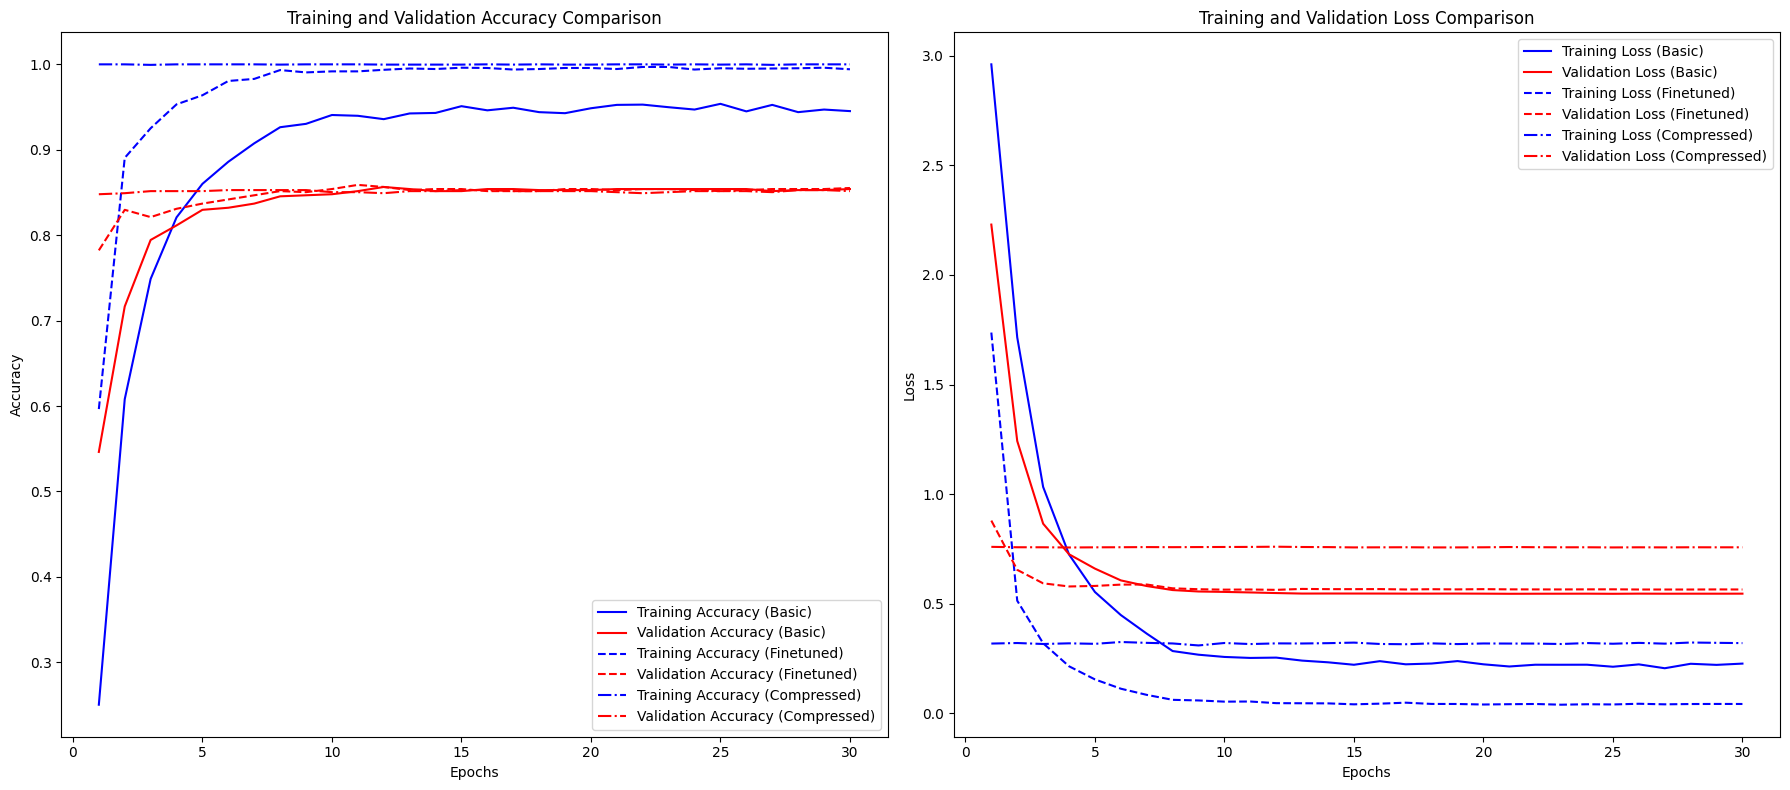

In [28]:
def plot_comparison_all(train_acc_before, val_acc_before, train_loss_before, val_loss_before,
                        train_acc_finetuned, val_acc_finetuned, train_loss_finetuned, val_loss_finetuned,
                        train_acc_compressed, val_acc_compressed, train_loss_compressed, val_loss_compressed):
    epochs = range(1, len(train_acc_before) + 1)

    plt.figure(figsize=(18, 8))

    # Plot accuracy comparison
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_before, 'b', label='Training Accuracy (Basic)')
    plt.plot(epochs, val_acc_before, 'r', label='Validation Accuracy (Basic)')
    plt.plot(epochs, train_acc_finetuned, 'b--', label='Training Accuracy (Finetuned)')
    plt.plot(epochs, val_acc_finetuned, 'r--', label='Validation Accuracy (Finetuned)')
    plt.plot(epochs, train_acc_compressed, 'b-.', label='Training Accuracy (Compressed)')
    plt.plot(epochs, val_acc_compressed, 'r-.', label='Validation Accuracy (Compressed)')
    plt.title('Training and Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss comparison
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_before, 'b', label='Training Loss (Basic)')
    plt.plot(epochs, val_loss_before, 'r', label='Validation Loss (Basic)')
    plt.plot(epochs, train_loss_finetuned, 'b--', label='Training Loss (Finetuned)')
    plt.plot(epochs, val_loss_finetuned, 'r--', label='Validation Loss (Finetuned)')
    plt.plot(epochs, train_loss_compressed, 'b-.', label='Training Loss (Compressed)')
    plt.plot(epochs, val_loss_compressed, 'r-.', label='Validation Loss (Compressed)')
    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_comparison_all(
    train_acc_history_model_MBV3small,
    val_acc_history_model_MBV3small,
    train_loss_history_model_MBV3small,
    val_loss_history_model_MBV3small,
    train_acc_history_model_finetuned,
    val_acc_history_model_finetuned,
    train_loss_history_model_finetuned,
    val_loss_history_model_finetuned,
    train_acc_history_compress,
    val_acc_history_compress,
    train_loss_history_compress,
    val_loss_history_compress
)